In [1]:
from tqdm import tqdm
import pandas as pd
import torch
import numpy as np
import matplotlib.pyplot as plt

from schnet_assignment.data import load_all_data
from schnet_assignment.models import SchNet

In [2]:
# some training hyperparameters
train_pct = 0.75
num_epochs = 5
batch_size = 5

In [3]:
all_data, embeddings = load_all_data()
all_data.head()

loading proteins...
loading labels...
loading esm embeddings...


esm_embeddings: 100%|██████████| 42/42 [02:55<00:00,  4.17s/it]

done.


,protein_name,coords,sequence,num_atoms,value
0,1a0g_1_protein,"[[62.54, 19.333, 31.113], [60.403, 22.375, 31....",GYTLWNDQIVKDEEVKIDKEDRGYQFGDGVYEVVKVYNGEMFTVNE...,562,107.810
1,1a4m_1_protein,"[[15.593, 32.439, 59.158], [19.13, 32.724, 57....",TPAFNKPKVELHVHLDGAIKPETILYFGKKRGIALPADTVEELRNI...,349,66.524
2,1a4r_1_protein,"[[64.709, 42.32, -10.655], [66.368, 41.699, -7...",MQTIKCVVVGDVAVGKTCLLISYTTNKFPSEYVPTVFDNYAVTVMI...,380,70.929
3,1a3k_1_protein,"[[21.973, -3.321, -6.727], [21.115, -5.91, -4....",LIVPYNLPLPGGVVPRMLITILGTVKPNANRIALDFQRGNDVAFHF...,137,26.262
4,1a0t_1_protein,"[[-45.764, 1.22, 8.776], [-43.638, 1.985, 5.71...",SGFEFHGYARSGVIMNDSGASTKSGAYITPAGETGGAIGRLGNQAD...,1239,228.810


In [4]:
# create train and test splits (for fun)
all_idxs = np.arange(all_data.shape[0])
train_idxs = np.random.choice(all_idxs, size=int(all_idxs.shape[0]*train_pct), replace=False)
test_idxs = all_idxs[~train_idxs]

train_data = all_data.iloc[train_idxs]
train_embeddings = [embeddings[e] for e in train_idxs]
 
test_data = all_data.iloc[test_idxs]
test_embeddings = [embeddings[e] for e in test_idxs]

In [5]:
# load model
model = SchNet(hidden_channels=train_embeddings[0].shape[1],num_interactions=3)

In [6]:
def prepare_batch_data(batch_data):
    coords = torch.FloatTensor(np.concatenate(batch_data['coords'].values))
    labels = torch.FloatTensor(batch_data['value'].values).unsqueeze(1)
    atom_counts = batch_data['num_atoms'].tolist()
    # batch indices are constant w.r.t. the number of atoms
    # per protein in each batch
    batch_indices = torch.zeros(coords.shape[0], dtype=torch.int64)
    
    for a in range(0,len(atom_counts)-1):
        asum = sum(atom_counts[:a])
        batch_indices[asum:asum+atom_counts[a+1]] = a+1

    return coords, labels, batch_indices


optimizer = torch.optim.Adam(model.parameters())
loss_fun = torch.nn.MSELoss()
training_losses = []
eval_losses = []

for epoch in tqdm(range(num_epochs), desc='training epochs'):
    # train
    for bix in range(0,train_data.shape[0],batch_size):
        optimizer.zero_grad()

        batch_data = train_data.iloc[bix:bix+batch_size]
        coords, labels, batch_indices = prepare_batch_data(batch_data)
        embs = torch.concatenate([train_embeddings[b] for b in range(bix,min(len(train_embeddings),bix+batch_size))])
        
        preds = model(embs, coords, batch=batch_indices)
        loss = loss_fun(preds, labels)
        
        loss.backward()
        optimizer.step()

        training_losses.append({'epoch':epoch, 'batch':bix, 'loss':loss.detach().numpy()})


    # evaluate
    for bix in range(0,test_data.shape[0],batch_size):

        with torch.no_grad():
            batch_data = test_data.iloc[bix:bix+batch_size]
            embs = embs = torch.concatenate([test_embeddings[b] for b in range(bix,min(len(test_embeddings),bix+batch_size))])
            coords, labels, batch_indices = prepare_batch_data(batch_data)
            
            preds = model(embs, coords, batch=batch_indices)
            loss = loss_fun(preds, labels)

            eval_losses.append({'epoch':epoch, 'batch':bix, 'loss':loss.detach().numpy()})
    

training epochs:   0%|          | 0/5 [00:00<?, ?it/s]

training epochs: 100%|██████████| 5/5 [00:48<00:00,  9.74s/it]


In [7]:
# make reporting nice for a plot
# `iteration` here is batch x epoch
train_info = pd.DataFrame(training_losses)
train_info['iteration'] = train_info['epoch']*train_info['batch'].max() + train_info['batch']

eval_info = pd.DataFrame(eval_losses)
max_eval_batch = train_info['batch'].max()
eval_info = eval_info.drop(columns='batch').groupby('epoch').mean().reset_index()
eval_info['iteration'] = (1+eval_info['epoch'])*max_eval_batch
eval_info

,epoch,loss,iteration
0,0,169725.303571,30
1,1,40452.361607,60
2,2,26568.9375,90
3,3,6376.780692,120
4,4,3193.859933,150


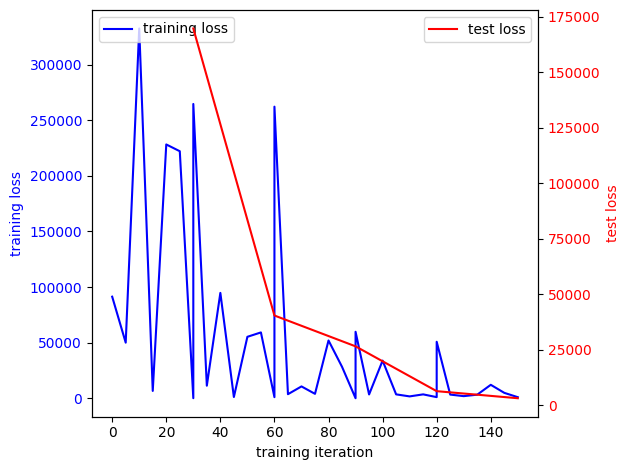

In [8]:
# plot losses.
# we could probably re-scale the training and test losses
# by accounting for difference in number of batches.
# this would avoid using two axes, but this is quicker
fig, ax1 = plt.subplots()

train_color = 'b'
ax1.set_xlabel('training iteration')
ax1.set_ylabel('training loss', color=train_color)
ax1.plot(train_info['iteration'], train_info['loss'], label='training loss', color=train_color)
ax1.tick_params(axis='y', labelcolor=train_color)
ax1.legend(loc='upper left')
ax2 = ax1.twinx()

test_color = 'r'
ax2.set_ylabel('test loss', color=test_color)
ax2.plot(eval_info['iteration'], eval_info['loss'], label='test loss', color=test_color)
ax2.tick_params(axis='y', labelcolor=test_color)

fig.tight_layout()
ax2.legend(loc='upper right')
plt.show()